In [1]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, gaiaAEN
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin

from QA import set_mwd, get_radec_mw
from io_ import get_isdes

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.table import Table

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
#
dr = 'dr9'
#survey = 'north' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
Nranfiles = 3
reg = 'desi'
dec_resol_ns = 32.375
if (dr == 'dr9sv'): Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20

pathdir = os.path.abspath(os.getcwd())+'/%s-%s_%s_bgs_check' %(dr, reg, version)
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)

# for healpy
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
dr9pix = '/global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/bright/pixweight-bright.fits'

if dr[:3] == 'dr8': pixfile = dr8pix
elif dr[:3] == 'dr9': pixfile = dr9pix
    
hdr          = fits.getheader(pixfile,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

``` Python
#
cols = ['TARGETID', 'DESI_TARGET', 'BGS_TARGET', 'RA', 'DEC', 'FLUX_R', 'FLUX_G', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2',
                    'FIBERFLUX_R', 'FIBERTOTFLUX_R','MW_TRANSMISSION_R', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1',
                        'MW_TRANSMISSION_W2', 'MASKBITS', 'REF_CAT', 'REF_ID', 
                            'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE', 'FRACFLUX_G', 
                                'FRACFLUX_R', 'FRACFLUX_Z', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z',
                                     'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'MORPHTYPE', 'FLUX_IVAR_R', 'FLUX_IVAR_G',
                                           'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 
                                                'NOBS_G', 'NOBS_R', 'NOBS_Z' 
]

cats = {}
path = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/desitarget/'
for i in ['1', '2', '3']:
    cat = np.load(os.path.join(path, 'dr9_0.58.0_bgs_any_%s.npy' %(i)))
    tab = Table()
    for col in cols:
        tab[col] = cat[col]
    np.save(os.path.join(path, 'LITE_dr9_0.58.0_bgs_any_%s.npy' %(i)), tab)
    cats[i] = tab
    del cat, tab

#
cat = np.concatenate(tuple(cats.values()))
cat = Table(cat)
cat['MORPHTYPE'].name = 'TYPE'

#
path = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/desitarget/'
np.save(os.path.join(path, 'LITE_dr9_0.58.0_bgs_any.npy'), cat)

#
verbose = True
#angle to healpy pixels array
hppix = hp.ang2pix(nside,(90.-cat['DEC'])*np.pi/180.,cat['RA']*np.pi/180.,nest=True)
if verbose: print('healpix DONE...')
c = SkyCoord(cat['RA']*units.degree,cat['DEC']*units.degree, frame='icrs')
b = c.galactic.b.value # galb coordinate
l = c.galactic.l.value # galb coordinate
if verbose: print('galactic coordinates DONE...')

cat['hppix'] = hppix
cat['b'] = b
cat['l'] = l

if verbose: print('Resolve north and south DONE...')

regs = ['des', 'decals', 'north', 'desi', 'south']
for i in regs:
    reg_ = get_reg(reg=i, hppix=hppix)
    cat[i] = reg_
    if verbose: print(i, 'DONE...')
        
#
path = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/desitarget/'
file = os.path.join(path, 'LITE_dr9_0.58.0_bgs_any.npy')
np.save(file, cat)
cat = getBGSbits(cat=None, mycatpath=file, outdir=None, mycat=True, getmycat=True, verbose=True, south=False)

#
path = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/desitarget/'
file = os.path.join(path, 'LITE_dr9_0.58.0_bgs_any_BGSBITS.npy')
np.save(file, cat)
```

In [3]:
path = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/desitarget/'
file = os.path.join(path, 'LITE_dr9_0.58.0_bgs_any_BGSBITS.npy')
cat = np.load(file)

In [4]:
#load catalogues
if dr == 'dr9sv': N = 1
else: N = Nranfiles

#CATALOGUE
#cat = np.load(filesdir+dr+'/'+version+'/'+'bgstargets'+'.npy', mmap_mode='r+')
catinreg = (cat[reg]) & (cat['desi'])
cat = cat[catinreg]
print('CATALOGUE DONE...')

#RANDOMS
ran = np.load(filesdir+dr+'/'+dr+'_random_N'+str(N)+'.npy', mmap_mode='r+')
ran_ex = np.load(filesdir+dr+'/'+'extra_random_N'+str(N)+'_n256.npy', mmap_mode='r+')
raninreg = (ran_ex[reg]) & (ran_ex['desi'])
ran = ran[raninreg]
ran_ex = ran_ex[raninreg]
print('RANDOMS DONE...')


CATALOGUE DONE...
RANDOMS DONE...


In [5]:
catinreg = np.ones(len(cat), dtype=bool)
raninreg = np.ones(len(ran), dtype=bool)

In [6]:
#bgsmask = bgsmask()
rancuts = getGeoCuts(ran, randoms=True)

## getting area of reg with healpix pixels (for flow charts...)

NOTE: if using SVFIELDS footprint, use `desifootprint=False` otherwise the area will be less than the current SVFIELDS due desi footprint chops out part of it.

In [7]:
#Notes: This hpdict is used to get the area only using the randoms. 
#This use the randoms within the DESI footprint and without any masking (maskrand=None) as we want the area without wholes.
hpdict0 = get_dict(cat=None, pixmapfile=pixfile, hppix_ran=ran_ex['hppix'], hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=None, 
                            desifootprint=True, namesels=None, target_outputs=False, log=False)

## BGS 1 per cent

In [9]:
#
main = {}
main['bgs_bright'] = ((cat['BGS_TARGET'] & 2**(1)) != 0)
main['bgs_faint'] = (cat['BGS_TARGET'] & 2**(0)) != 0
main['bgs_wise'] = (cat['BGS_TARGET'] & 2**(2)) != 0
main['bgs_hip'] = (cat['BGS_TARGET'] & 2**(3)) != 0
main['bgs_any'] = (main['bgs_bright']) | (main['bgs_faint']) | (main['bgs_wise']) #(cat['DESI_TARGET'] & 2**(60)) != 0



    BGS_ANY          bit 60 mask 0x1000000000000000 - Any BGS bit is set
    
    BGS_FAINT        bit 0 mask 0x1 - BGS faint targets
    BGS_BRIGHT       bit 1 mask 0x2 - BGS bright targets
    BGS_WISE         bit 2 mask 0x4 - BGS wise targets
    BGS_FAINT_HIP    bit 3 mask 0x8 - BGS faint targets at bright priority
    BGS_FAINT_NORTH  bit 8 mask 0x100 - BGS faint cuts tuned for Bok/Mosaic
    BGS_BRIGHT_NORTH bit 9 mask 0x200 - BGS bright cuts tuned for Bok/Mosaic
    BGS_WISE_NORTH   bit 10 mask 0x400 - BGS WISE cuts tuned for Bok/Mosaic
    BGS_FAINT_SOUTH  bit 16 mask 0x10000 - BGS faint cuts tuned for DECam
    BGS_BRIGHT_SOUTH bit 17 mask 0x20000 - BGS bright cuts tuned for DECam
    BGS_WISE_SOUTH   bit 18 mask 0x40000 - BGS WISE cuts tuned for DECam

## Healpy pixels catalogue with BGS target density (for dens. sky maps and systematics plots...)

In [10]:
#dic with default BGS selection and in DESI footprint
hpdict = get_dict(cat=cat, pixmapfile=pixfile, hppix_ran=ran_ex['hppix'], hppix_cat=cat['hppix'], 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs'])), maskcat=None, 
                          Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=cat['desi'], desifootprint=True, 
                              namesels=main, galb=cat['b'], log=False, survey='custom')

## BGS outline

In [11]:
if reg == 'desi':
    survey = 'all'
    bgsarea = 'area'
else:
    survey = reg
    bgsarea = 'bgsarea'

In [12]:
for key, val in main.items():
    print(key, np.sum(val)/hpdict0['area_all'])

bgs_bright 853.1259986656768
bgs_faint 525.8928329635045
bgs_wise 3.067802823472113
bgs_hip 105.16756133637084
bgs_any 1382.0866344526535


In [13]:
Ared = hpdict['%s_%s' %(bgsarea, survey)]
Ared_n = hpdict['bgsarea_north']
Ared_s = hpdict['bgsarea_south']
print(Ared, Ared_n, Ared_s)

14081.685866666665 4493.085 9588.600866666664


In [14]:
#
import pandas as pd
densities = {'BGS':[], 'BASS/MzLS':[], 'DECaLS':[]}
N = 1
for key, val in zip(main.keys(), main.values()):
    
    densities['BGS'].append(key)
    densities['BASS/MzLS'].append(np.round(np.sum((val) & (cat['north']))/hpdict['%s_%s' %('bgsarea', 'north')], N))
    densities['DECaLS'].append(np.round(np.sum((val) & (cat['south']))/hpdict['%s_%s' %('bgsarea', 'south')], N))
#     densities['DECaLS SGC'].append(np.round(np.sum((val) & (cat['south']) & (cat['b'] < 0))/hpdict['%s_%s' %('bgsarea', 'south_s')], N))
    #densities['DESI'].append(np.round(np.sum(val)/hpdict['%s_%s' %(bgsarea, survey)], 0))

densities['BGS'].append('AREA')
densities['BASS/MzLS'].append(hpdict['%s_%s' %('bgsarea', 'north')])
densities['DECaLS'].append(hpdict['%s_%s' %('bgsarea', 'south')])
# densities['DECaLS SGC'].append(hpdict['%s_%s' %('bgsarea', 'south_s')])

tab = pd.DataFrame.from_dict(densities)

In [15]:
tab

BGS  BASS/MzLS       DECaLS
0  bgs_bright    865.400   863.800000
1   bgs_faint    531.400   533.400000
2    bgs_wise      3.400     3.000000
3     bgs_hip    106.400   106.600000
4     bgs_any   1400.200  1400.100000
5        AREA   4493.085  9588.600867

## Number counts

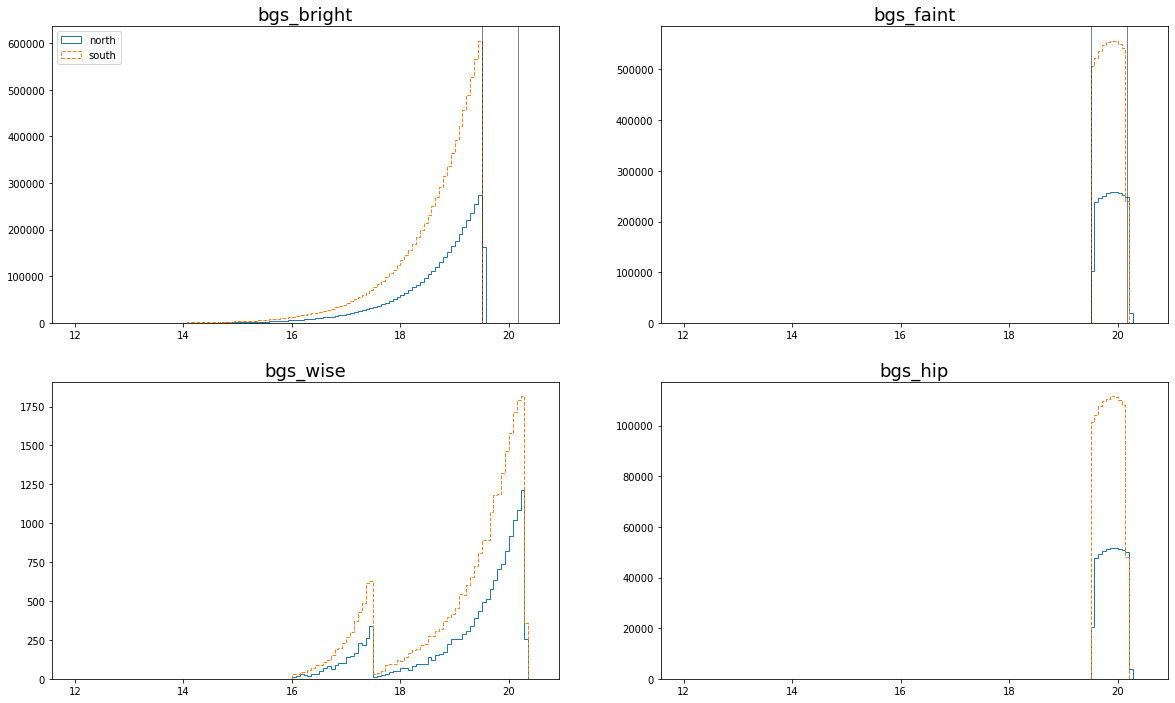

In [16]:
#
plt.figure(figsize=(20,12))
bins = np.linspace(12, 20.5, 120)
for num, (key, val) in enumerate(main.items()):
    
    if key == 'bgs_any': continue
    
    plt.subplot(2,2,num+1)
    plt.title(key, size=18)
    plt.hist(cat['RMAG'][(val) & (cat['north'])], bins=bins, histtype='step', ls='-', label='%s' %('north') if num == 0 else None)
    plt.hist(cat['RMAG'][(val) & (cat['south'])], bins=bins, histtype='step', ls='--', label='%s' %('south') if num == 0 else None)
    
    if num == 0: plt.legend()
    
    if num < 2:
        for i in [19.5, 20.175]:
            plt.axvline(i, c='k', lw=0.5)
    

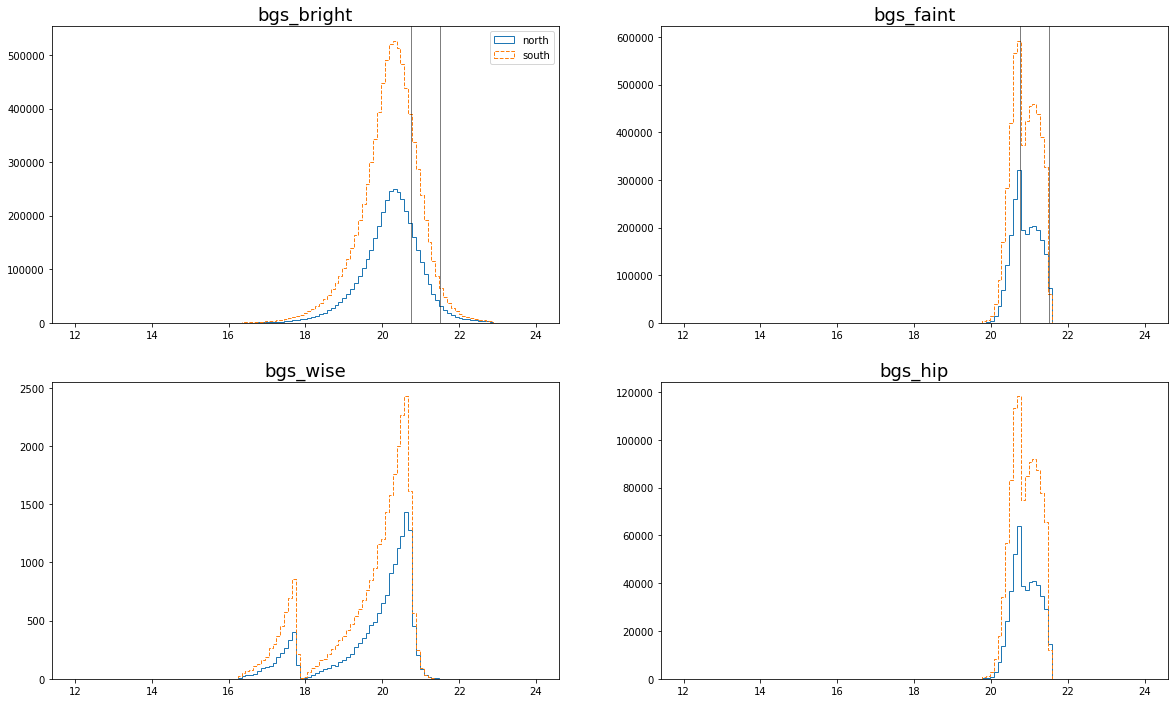

In [17]:
#
plt.figure(figsize=(20,12))
bins = np.linspace(12, 24, 120)
for num, (key, val) in enumerate(main.items()):
    
    if key == 'bgs_any': continue
    
    plt.subplot(2,2,num+1)
    plt.title(key, size=18)
    plt.hist(cat['RFIBERMAG'][(val) & (cat['north'])], bins=bins, histtype='step', ls='-', label='%s' %('north') if num == 0 else None)
    plt.hist(cat['RFIBERMAG'][(val) & (cat['south'])], bins=bins, histtype='step', ls='--', label='%s' %('south') if num == 0 else None)
    
    if num == 0: plt.legend()
    
    if num < 2:
        for i in [20.75, 21.5]:
            plt.axvline(i, c='k', lw=0.5)
    

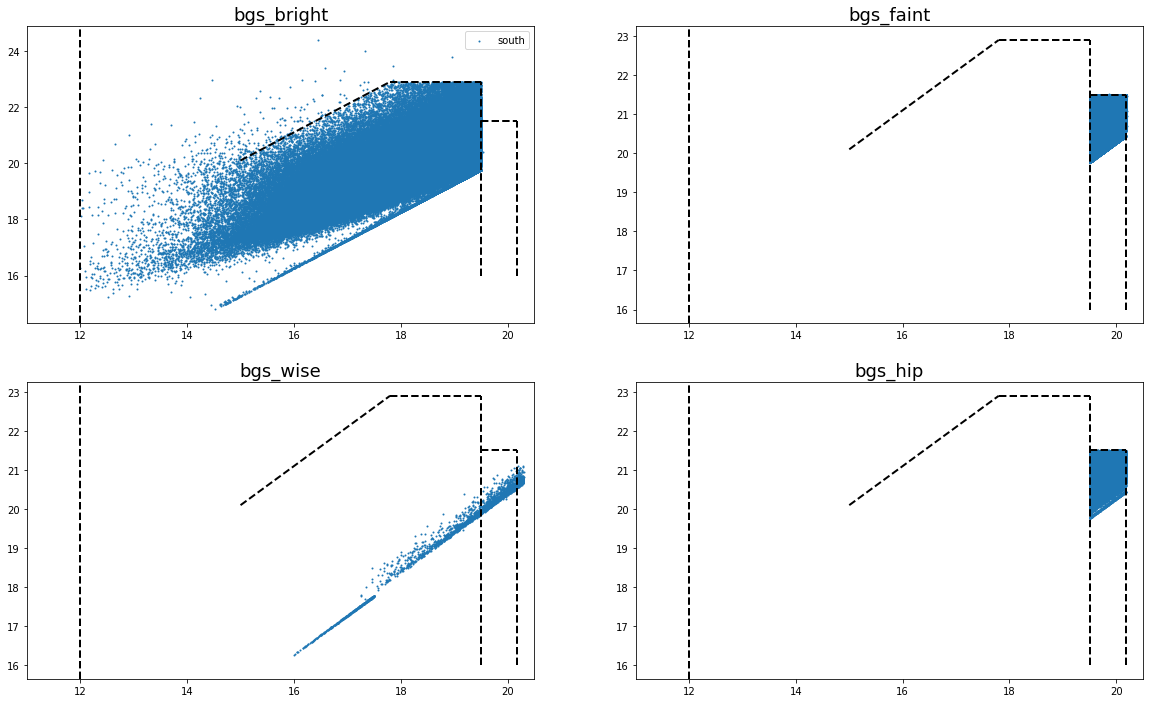

In [18]:
#
plt.figure(figsize=(20,12))
bins = np.linspace(12, 24, 120)
for num, (key, val) in enumerate(main.items()):
    
    if key == 'bgs_any': continue
    
    plt.subplot(2,2,num+1)
    plt.title(key, size=18)
    keeps = (val) & (cat['south'])
    N = 10
    plt.scatter(cat['RMAG'][keeps][::N], cat['RFIBERMAG'][keeps][::N], s=1, label='%s' %('south') if num == 0 else None)

    plt.axvline(12, linewidth=2, linestyle='--', color='k')
    plt.plot([15, 17.8], [20.1, 22.9], c='k', ls='--', lw=2)
    plt.plot([17.8, 19.5], [22.9, 22.9], c='k', ls='--', lw=2)
    plt.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=2)
    plt.plot([19.5, 20.175], [21.5, 21.5], c='k', ls='--', lw=2)
    plt.plot([20.175, 20.175], [16, 21.5], c='k', ls='--', lw=2)
    
    plt.xlim(11, 20.5)
    
    if num == 0: plt.legend()
    

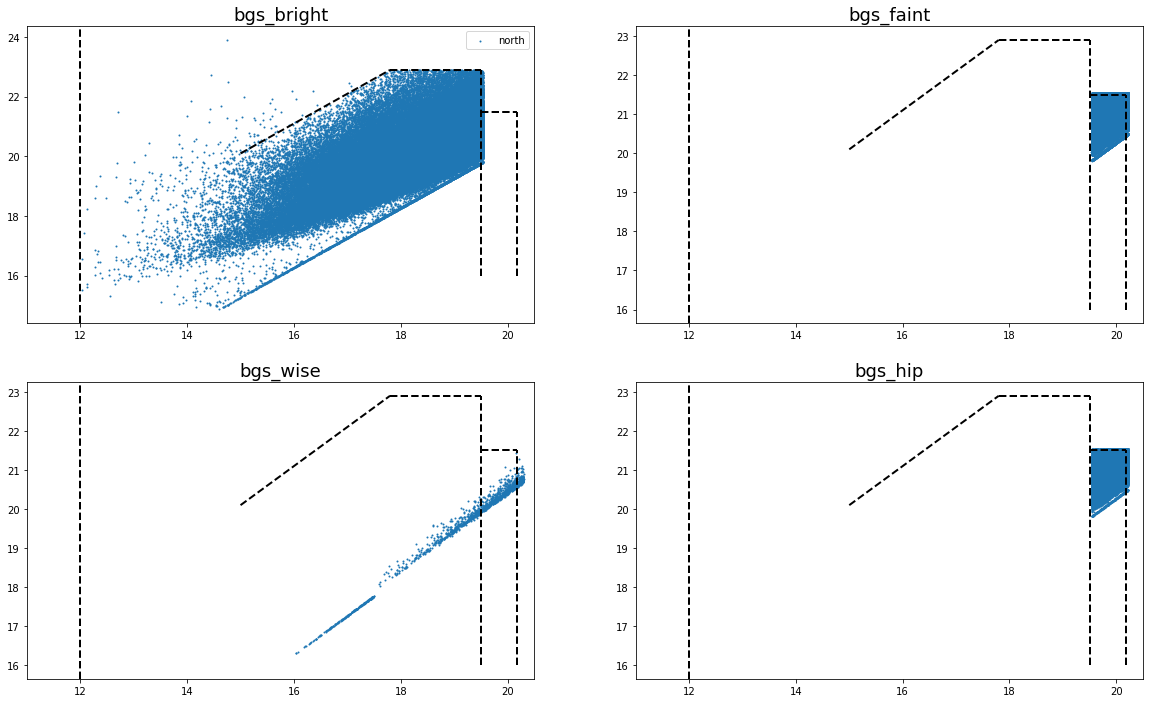

In [19]:
#
plt.figure(figsize=(20,12))
bins = np.linspace(12, 24, 120)
for num, (key, val) in enumerate(main.items()):
    
    if key == 'bgs_any': continue
    
    plt.subplot(2,2,num+1)
    plt.title(key, size=18)
    keeps = (val) & (cat['north'])
    N = 10
    plt.scatter(cat['RMAG'][keeps][::N], cat['RFIBERMAG'][keeps][::N], s=1, label='%s' %('north') if num == 0 else None)

    plt.axvline(12, linewidth=2, linestyle='--', color='k')
    plt.plot([15, 17.8], [20.1, 22.9], c='k', ls='--', lw=2)
    plt.plot([17.8, 19.5], [22.9, 22.9], c='k', ls='--', lw=2)
    plt.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=2)
    plt.plot([19.5, 20.175], [21.5, 21.5], c='k', ls='--', lw=2)
    plt.plot([20.175, 20.175], [16, 21.5], c='k', ls='--', lw=2)
    
    plt.xlim(11, 20.5)
    
    if num == 0: plt.legend()
    

## BGS dens. sky maps

In [20]:
from QA import mollweide, mycmap, plot_sysdens
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

In [21]:
keys = list(main.keys())
print(keys)

['bgs_bright', 'bgs_faint', 'bgs_wise', 'bgs_hip', 'bgs_any']


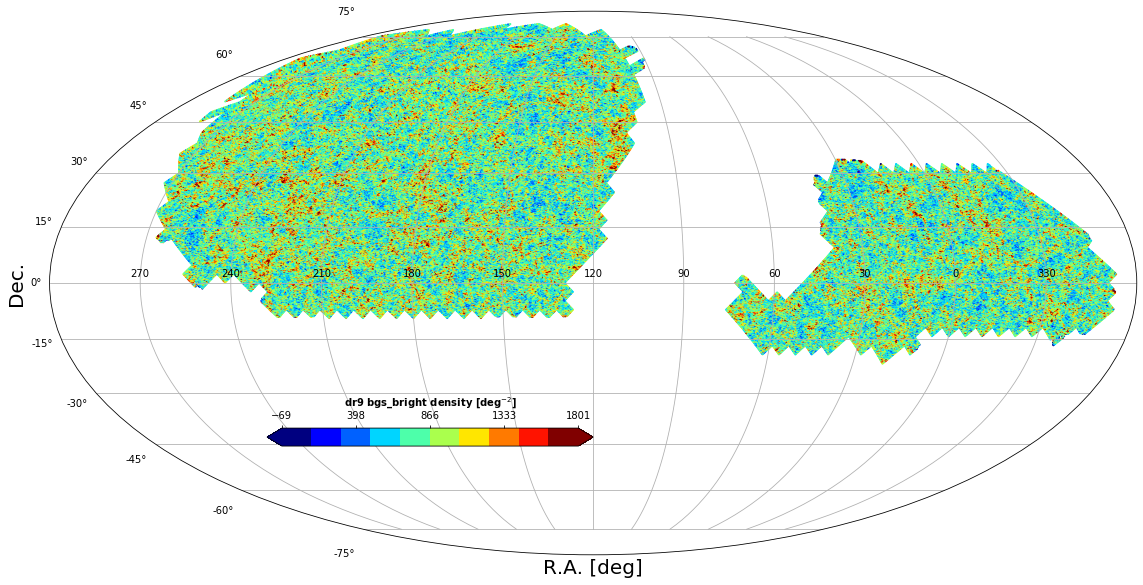

In [22]:
#   
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 1)
key = 'bgs_bright'

org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

mollweide(hpdict=hpdict, namesel=key, reg=survey, projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None, perc=(0.3,99.7), dr=dr, cname=None)

file = '%s/skydens_%s_%s' %(pathdir, dr, key)
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

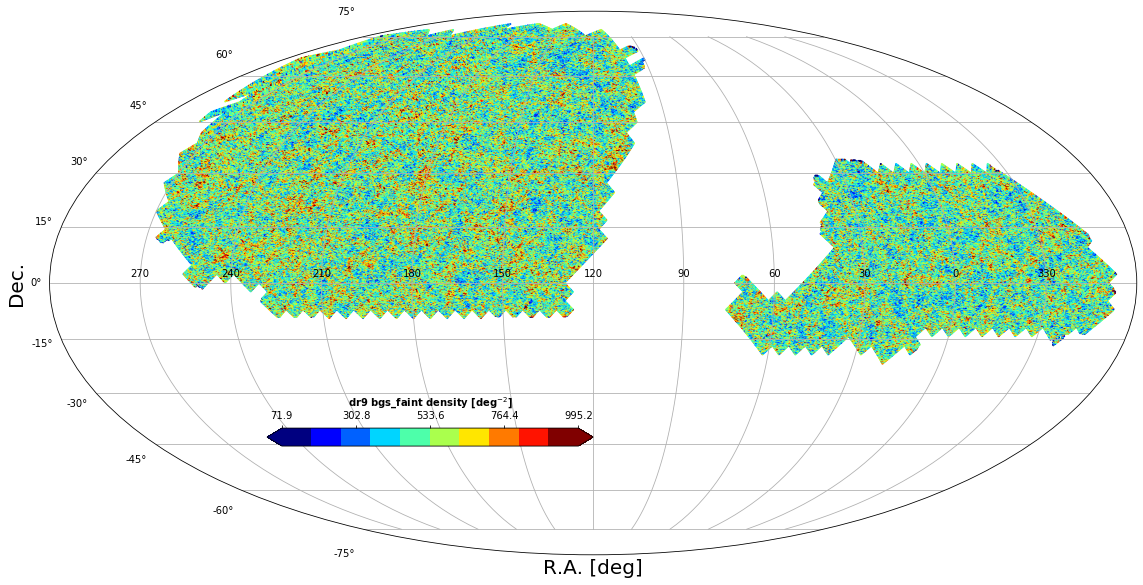

In [23]:
#   
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 1)
key = 'bgs_faint'

org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

mollweide(hpdict=hpdict, namesel=key, reg=survey, projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None, perc=(0.3,99.7), dr=dr)

file = '%s/skydens_%s_%s' %(pathdir, dr, key)
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

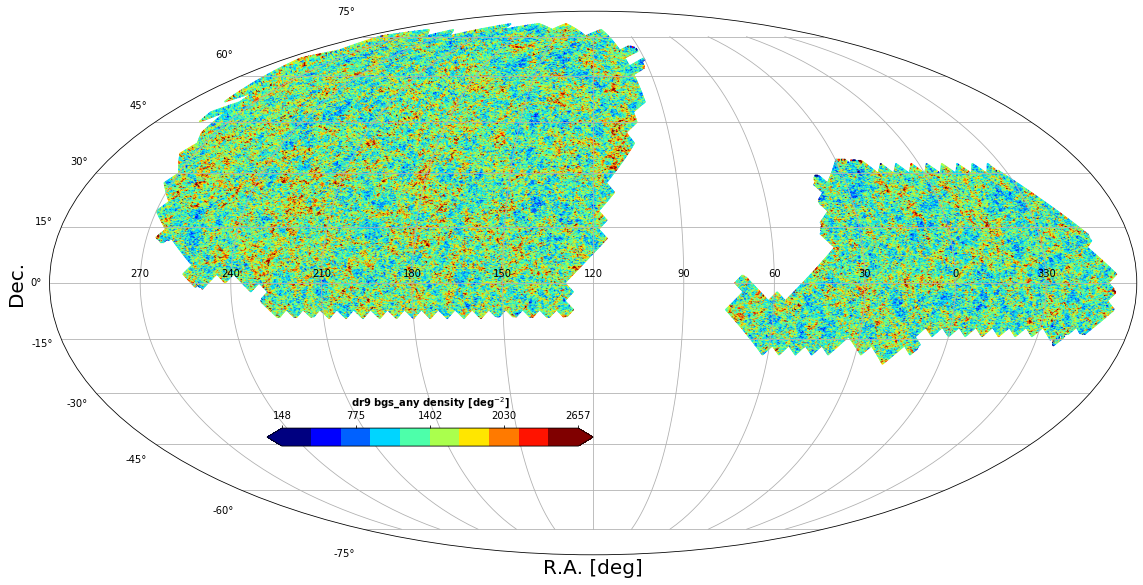

In [24]:
#   
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 1)
key = 'bgs_any'

org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

mollweide(hpdict=hpdict, namesel=key, reg=survey, projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None, perc=(0.3,99.7), dr=dr)

file = '%s/skydens_%s_%s' %(pathdir, dr, key)
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

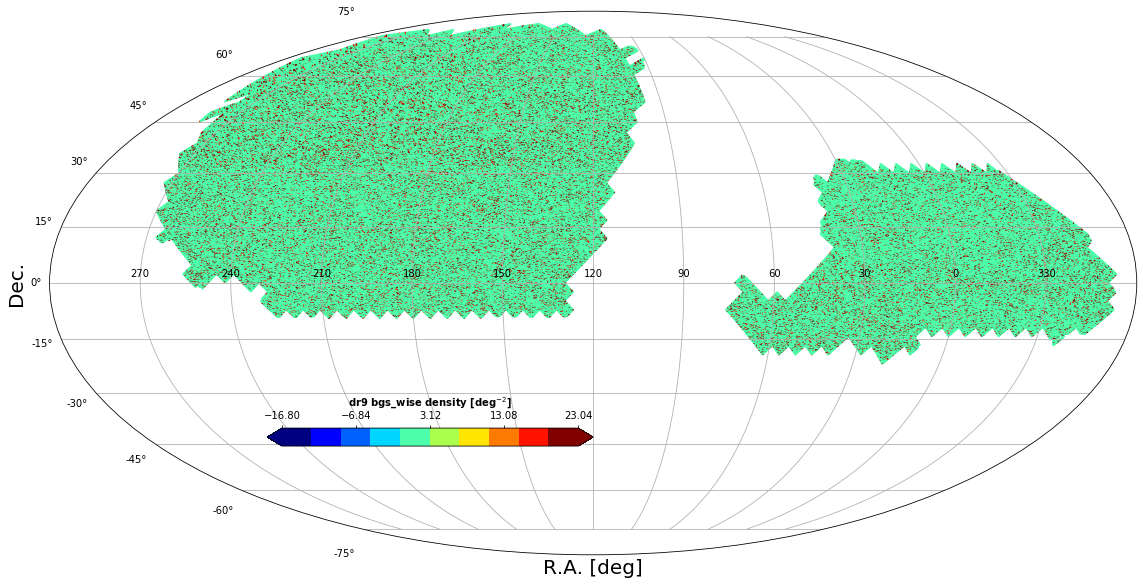

In [25]:
#   
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 1)
key = 'bgs_wise'

org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

mollweide(hpdict=hpdict, namesel=key, reg=survey, projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None, perc=(0.3,99.7), dr=dr)

file = '%s/skydens_%s_%s' %(pathdir, dr, key)
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

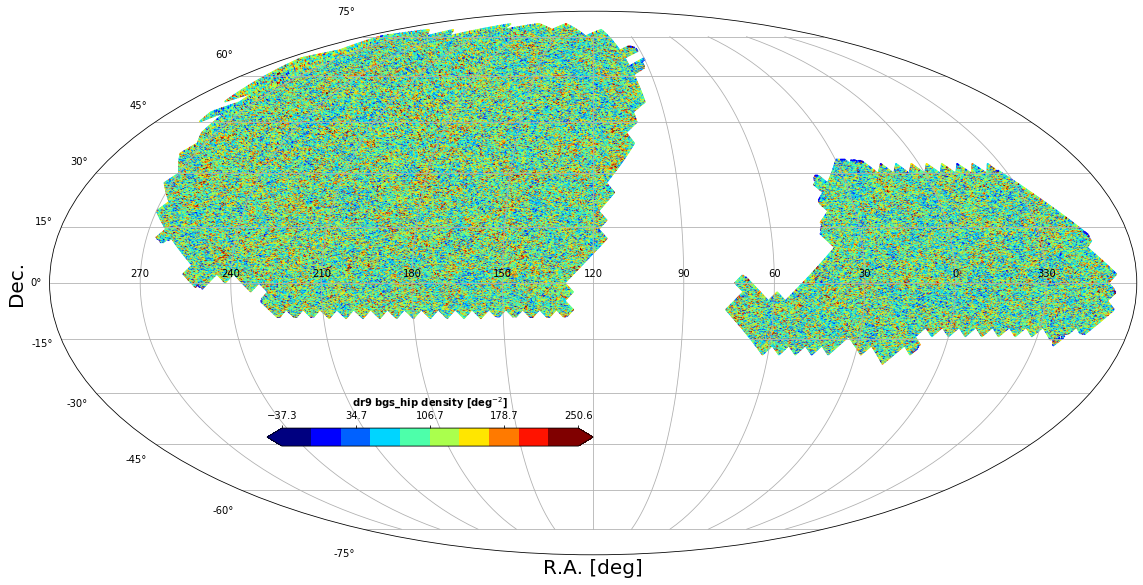

In [26]:
#   
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 1)
key = 'bgs_hip'

org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

mollweide(hpdict=hpdict, namesel=key, reg=survey, projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None, perc=(0.3,99.7), dr=dr)

file = '%s/skydens_%s_%s' %(pathdir, dr, key)
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

## g-r vs r-z 

In [27]:
def draw_arrow(x0, y0, x1, y1, lab, xc, yc, ax):
    
    ax.annotate("", xy=(x0, y0), xytext=(x1, y1),
             arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3"))
    #"<->"

    ax.text(xc, yc, lab,
         {'color': 'black', 'fontsize': 14, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
    

In [28]:
regis = {'BASS+MzLS':cat['north'], 'DECaLS':(cat['south'])}
regis_dict = {'BASS+MzLS':'north', 'DECaLS':'south'}

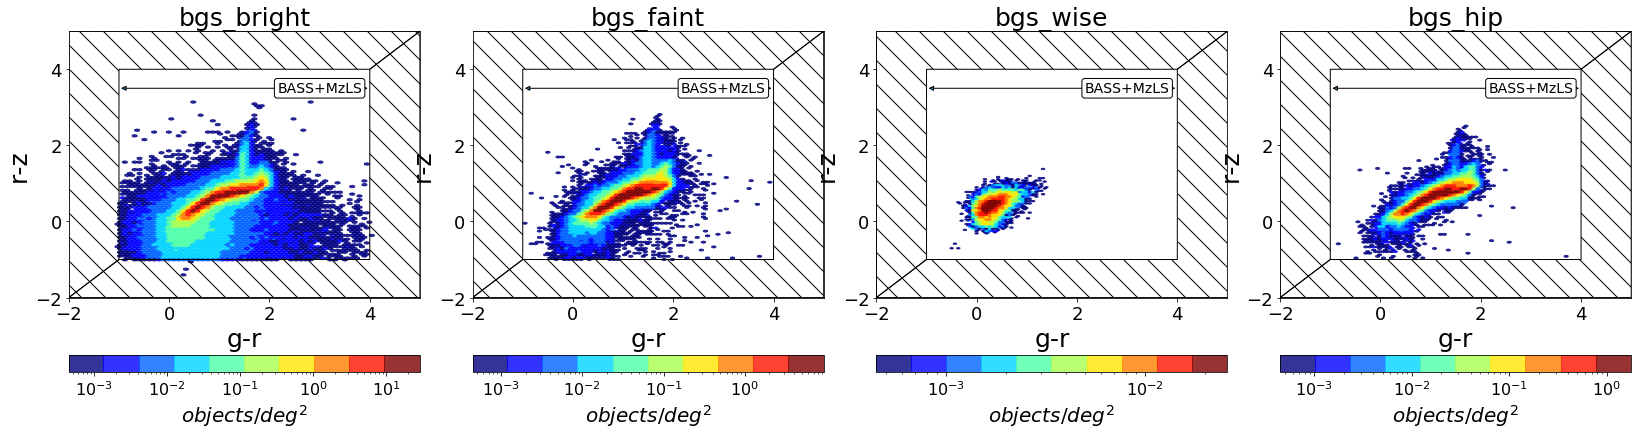

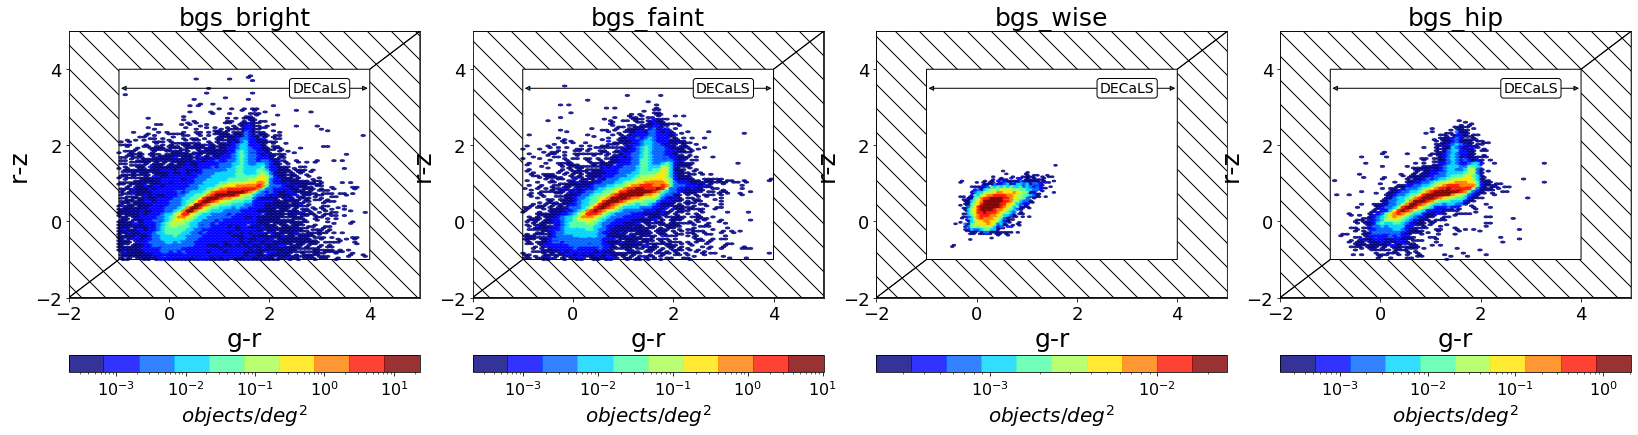

In [29]:
#
coord = {'g-r':cat['GMAG'] - cat['RMAG'], 'r-z':cat['RMAG'] - cat['ZMAG']}
cmap = plt.get_cmap('jet', 10)

mainlist = ['bgs_bright', 'bgs_faint', 'bgs_wise', 'bgs_hip']

for regi, val in regis.items():
    
    fig   = plt.figure(figsize=(7*len(mainlist),7))
    gs     = gridspec.GridSpec(1, 1*len(mainlist), hspace=0.2, wspace=0.15)
    
    Ared = hpdict['bgsarea_%s' %(regis_dict[regi])]

    for num, key in enumerate(mainlist):

        mask = (main[key]) & (val) #& (cat['TYPE'] == 'REX')

        ax = hexbin(coord=coord, C=np.full(len(mask), 1/Ared), clab='$objects/deg^{2}$', catmask=mask, n=num, bins='log', title=key, cmap=cmap, 
                   ylab=True, vline=None, hline=None, fig=fig, gs=gs, xlim=(-2, 5), ylim=(-2, 5), 
                       vmin=None, vmax=None, mincnt=1, fmcline=False,
                           file=None, fracs=False, area=Ared, cbar='horizontal', reduce_C_function=np.sum)

        #ax.legend()
        #hatch
        plt.fill([-2, 5, 5, 4, 4, -1], [-2, -2, 5, 4, -1, -1], fill=False, hatch='\\')
        plt.fill([-2, -2, 5, 4, -1, -1], [-2, 5, 5, 4, 4, -1], fill=False, hatch='\\')

        #draw arrows    
        draw_arrow(-1, 3.5, 4, 3.5, regi, 3, 3.5, ax)


    file='%s/gr_rz_hexbin_%s' %(pathdir, regi)
    fig.savefig(file, bbox_inches = 'tight', pad_inches = 0)


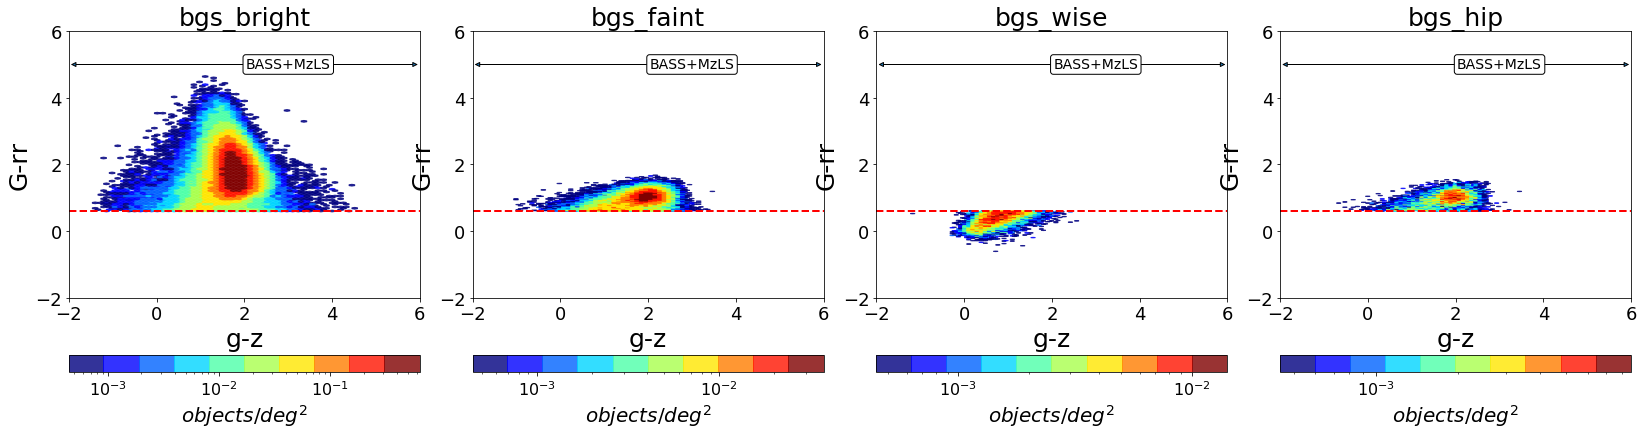

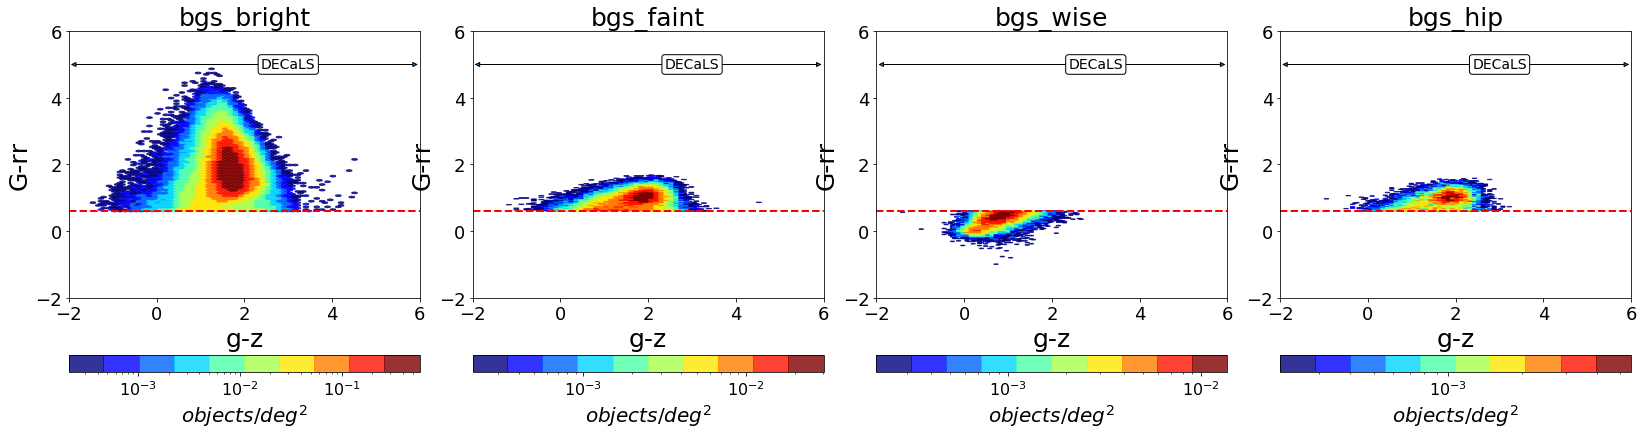

In [30]:
#
Grr = cat['G'] - flux_to_mag(cat['FLUX_R'])
coord = {'g-z':cat['GMAG'] - cat['ZMAG'], 'G-rr':Grr}

cmap = plt.get_cmap('jet', 10)

mainlist = ['bgs_bright', 'bgs_faint', 'bgs_wise', 'bgs_hip']

for regi, val in regis.items():
    
    fig   = plt.figure(figsize=(7*len(mainlist),7))
    gs     = gridspec.GridSpec(1, 1*len(mainlist), hspace=0.2, wspace=0.15)
    
    Ared = hpdict['bgsarea_%s' %(regis_dict[regi])]

    for num, key in enumerate(mainlist):

        mask = (main[key]) & (val) #& (cat['TYPE'] == 'REX')

        ax = hexbin(coord=coord, C=np.full(len(mask), 1/Ared), clab='$objects/deg^{2}$', catmask=mask, n=num, bins='log', title=key, cmap=cmap, 
                   ylab=True, vline=None, hline=0.6, fig=fig, gs=gs, xlim=(-2, 6), ylim=(-2, 6), 
                       vmin=None, vmax=None, mincnt=1, fmcline=False,
                           file=None, fracs=False, area=Ared, cbar='horizontal', reduce_C_function=np.sum)

        #ax.legend()
        #hatch
#         plt.fill([-2, 5, 5, 4, 4, -1], [-2, -2, 5, 4, -1, -1], fill=False, hatch='\\')
#         plt.fill([-2, -2, 5, 4, -1, -1], [-2, 5, 5, 4, 4, -1], fill=False, hatch='\\')

        #draw arrows    
        draw_arrow(-2, 5, 6, 5, regi, 3, 5, ax)


    file='%s/gz_Grr_hexbin_%s' %(pathdir, regi)
    fig.savefig(file, bbox_inches = 'tight', pad_inches = 0)


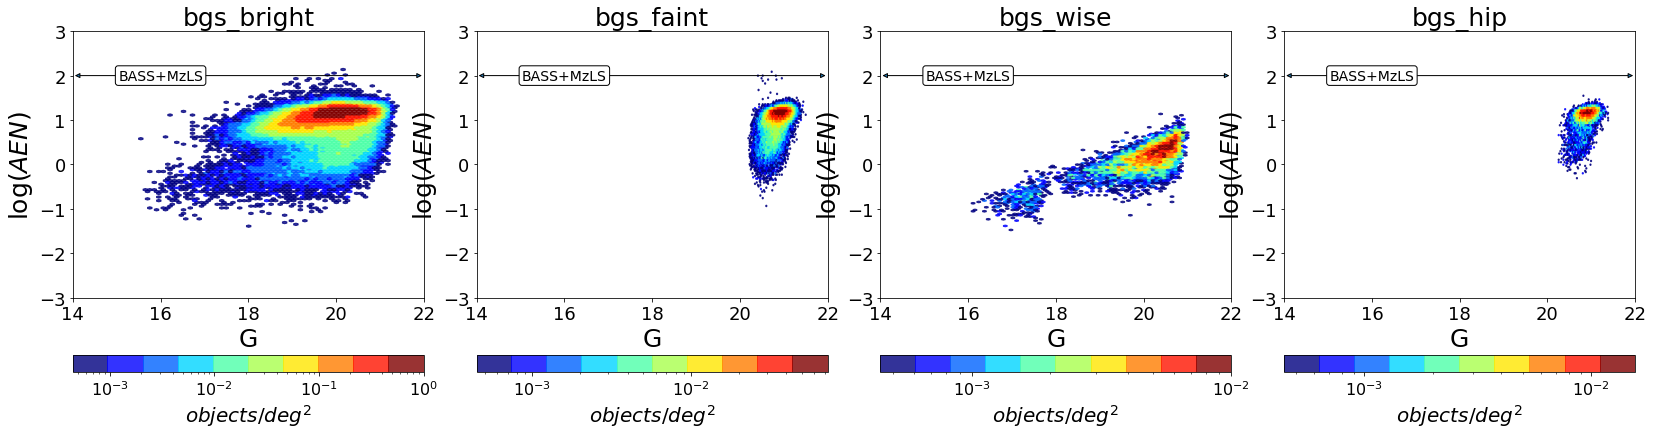

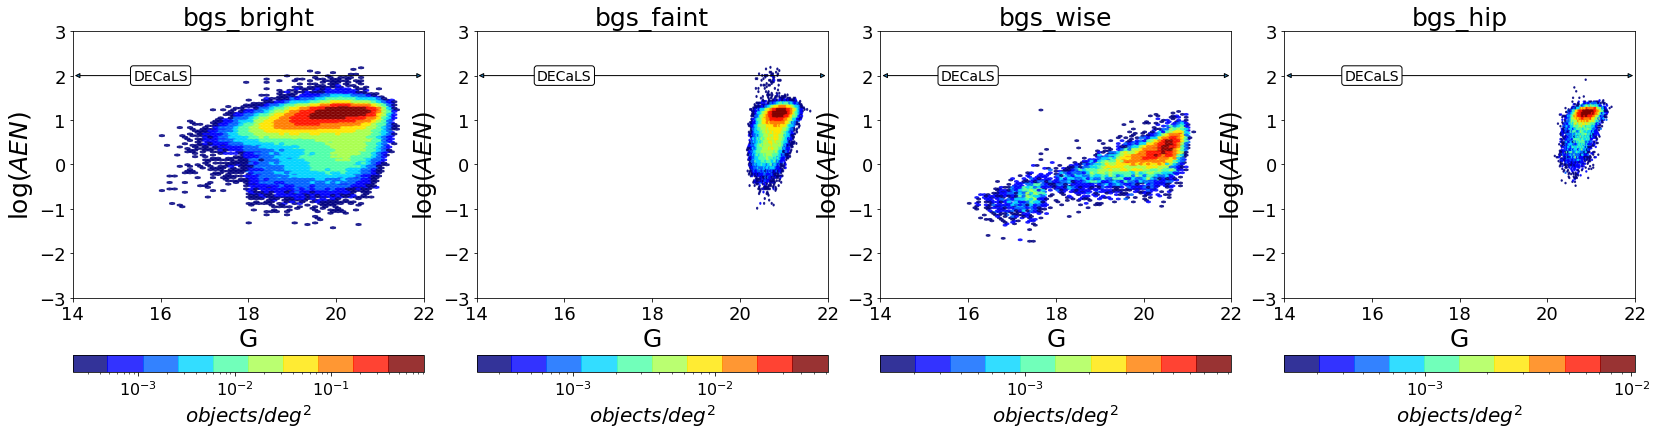

In [31]:
#
coord = {'G':cat['G'], r'$\log(AEN)$':np.log10(cat['AEN'])}

cmap = plt.get_cmap('jet', 10)

mainlist = ['bgs_bright', 'bgs_faint', 'bgs_wise', 'bgs_hip']

for regi, val in regis.items():
    
    fig   = plt.figure(figsize=(7*len(mainlist),7))
    gs     = gridspec.GridSpec(1, 1*len(mainlist), hspace=0.2, wspace=0.15)
    
    Ared = hpdict['bgsarea_%s' %(regis_dict[regi])]

    for num, key in enumerate(mainlist):

        mask = (main[key]) & (val) #& (cat['TYPE'] == 'REX')

        ax = hexbin(coord=coord, C=np.full(len(mask), 1/Ared), clab='$objects/deg^{2}$', catmask=mask, n=num, bins='log', title=key, cmap=cmap, 
                   ylab=True, vline=None, hline=None, fig=fig, gs=gs, xlim=(14, 22), ylim=(-3, 3), 
                       vmin=None, vmax=None, mincnt=1, fmcline=False,
                           file=None, fracs=False, area=Ared, cbar='horizontal', reduce_C_function=np.sum)

        #ax.legend()
        #hatch
#         plt.fill([-2, 5, 5, 4, 4, -1], [-2, -2, 5, 4, -1, -1], fill=False, hatch='\\')
#         plt.fill([-2, -2, 5, 4, -1, -1], [-2, 5, 5, 4, 4, -1], fill=False, hatch='\\')

        #draw arrows    
        draw_arrow(14, 2, 22, 2, regi, 16, 2, ax)


    file='%s/G_AEN_hexbin_%s' %(pathdir, regi)
    fig.savefig(file, bbox_inches = 'tight', pad_inches = 0)


## SGA's in NOBS, CC, and FIBMAG

In [32]:
cuts = {}

rmag = cat['RMAG']
gmag = cat['GMAG']
zmag = cat['ZMAG']
rfibmag = cat['RFIBERMAG']
nomask = np.zeros_like(cat['RA'], dtype='?')

FMC2 = nomask.copy()
delta = 1.0
FMC2 |= ((rfibmag < (2.9 + 1.2 + delta) + rmag) & (rmag < 18.8 - delta))
FMC2 |= ((rfibmag < 22.9) & (rmag < 20) & (rmag > 18.8 - delta))
FMC2 |= ((rfibmag < 2.9 + rmag) & (rmag > 20))

CC = ~nomask.copy()
CC &= ((gmag - rmag) > -1.)
CC &= ((gmag - rmag) < 4.)
CC &= ((rmag - zmag) > -1.)
CC &= ((rmag - zmag) < 4.)
    
cuts['nobs'] = (cat['NOBS_G'] > 0) & (cat['NOBS_R'] > 0) & (cat['NOBS_Z'] > 0)
cuts['fmc'] = FMC2
cuts['cc'] = CC

In [33]:
LG = cat['REF_CAT'] == b'L3'

In [34]:
tab = {i:[] for i in cuts.keys()}
for key, val in main.items():
    for key2, val2 in cuts.items():
        N = np.sum((val) & (~val2) & (LG))/Ared
        tab[key2].append(np.round(N, 5))
        
tab1 = pd.DataFrame(tab, index=main.keys())

In [35]:
tab1

nobs      fmc      cc
bgs_bright  0.01272  0.66548  0.0097
bgs_faint   0.00000  0.00000  0.0001
bgs_wise    0.00000  0.00000  0.0000
bgs_hip     0.00000  0.00000  0.0000
bgs_any     0.01272  0.66548  0.0098

# Contamination around Bright Stars

In [36]:
stars = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/stars/bright_stars.npy')

In [37]:
#Dustin_radii's
mag = np.linspace(0, 20, 80)
BS_radii = []
new_BS_radii = []
dr9_BS_radii = []
for i,j in enumerate(mag):
    BS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    new_BS_radii.append([j, 0.5 * np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    dr9_BS_radii.append([j, 0.5 * 1630./1. * 1.396**(-j)])

$R_{\rm BS}(m) = 815 \times 1.396^{-m} \,\, {\rm arcsec}$

``` python
#Dustin_radii's
mag = np.linspace(0, 20, 50)
BS_radii = []
new_BS_radii = []
for i,j in enumerate(mag):
    BS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    new_BS_radii.append([j, 0.5 * np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    
#star catalogue (use stars from sweeps in dr8 for now...)
stars_path = os.path.join(filesdir, 'dr8', 'stars_GAIA_TYCHO_13.npy')
stars = np.load(stars_path)

hppix_stars = hp.ang2pix(nside,(90.-stars['DEC'])*np.pi/180.,stars['RA']*np.pi/180.,nest=True) # catalogue hp pixels array
c = SkyCoord(stars['RA']*units.degree,stars['DEC']*units.degree, frame='icrs')
b = c.galactic.b.value # galb coordinate

regis_stars = {}

desi_stars = get_reg(reg='desi', hppix=hppix_stars)
south_stars = get_reg(reg='south', hppix=hppix_stars)
north_stars = get_reg(reg='north', hppix=hppix_stars)

regis_stars['north'] = (north_stars) & (desi_stars)
regis_stars['south_s'] = (south_stars) & (b < 0) & (desi_stars)
regis_stars['south_n'] = (south_stars) & (b > 0) & (desi_stars)
```

In [38]:
#
regis_stars = {}
regis_stars['north'] = (stars['north']) & (stars['desi'])
regis_stars['south'] = (stars['south']) & (stars['desi'])

regis = {'BASS+MzLS':cat['north'], 'DECaLS':(cat['south'])}
regis_dict = {'BASS+MzLS':'north', 'DECaLS':'south'}

mag_bins_len: 2


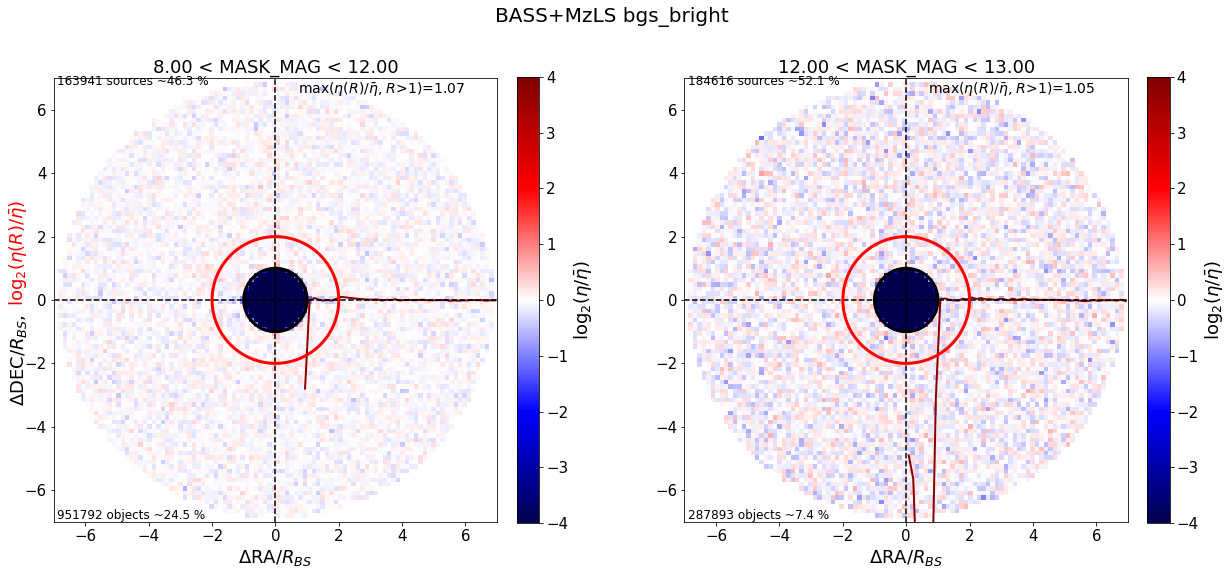

mag_bins_len: 2


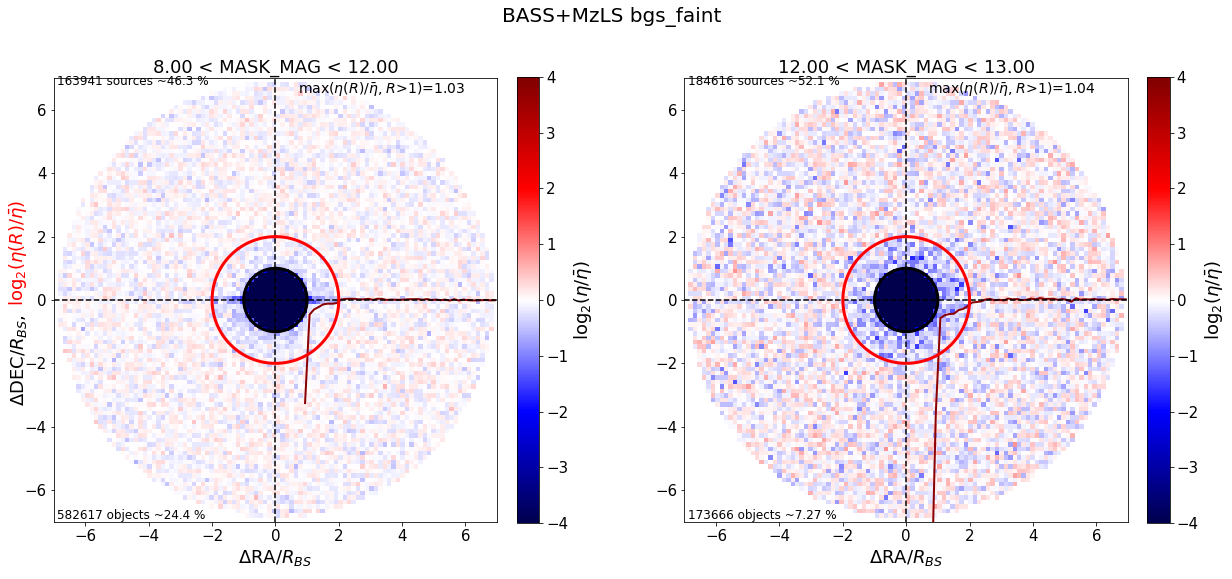

mag_bins_len: 2


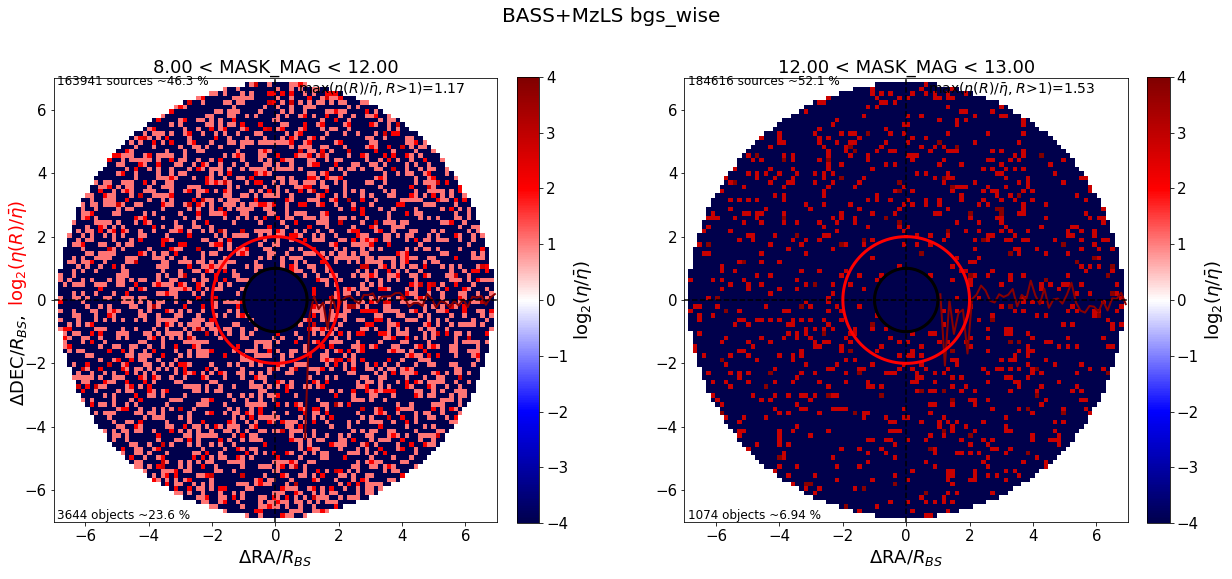

mag_bins_len: 2


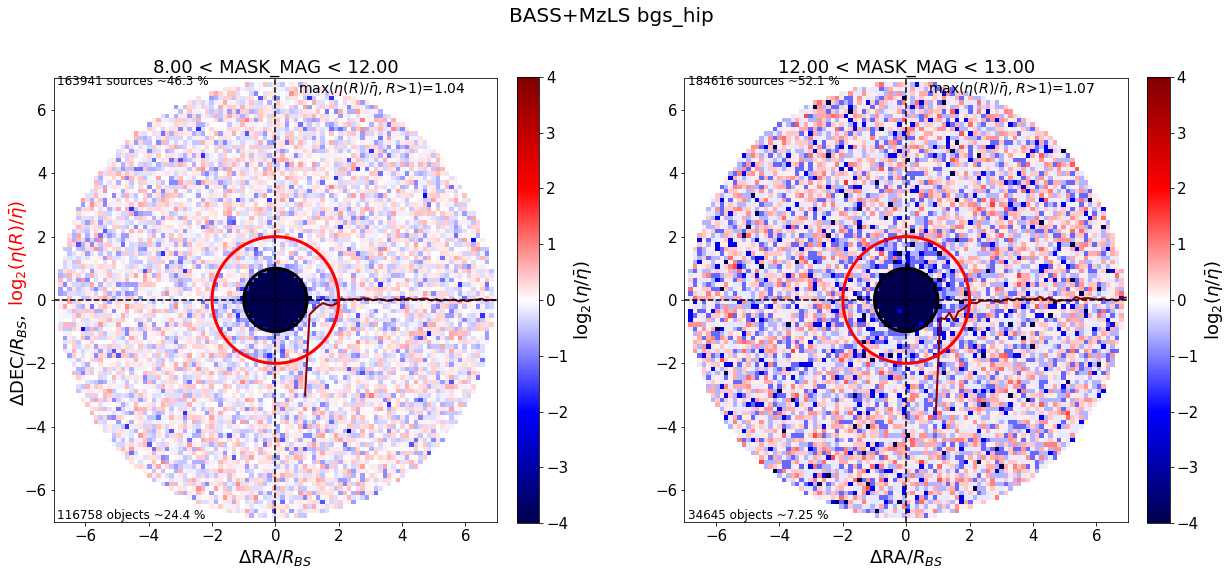

mag_bins_len: 2


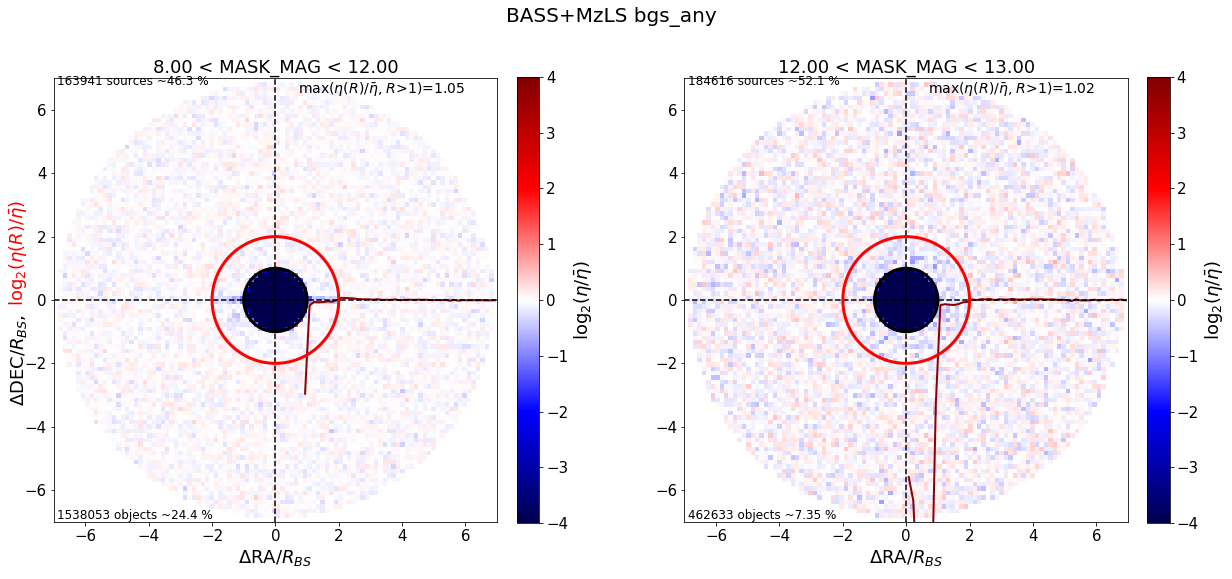

mag_bins_len: 2


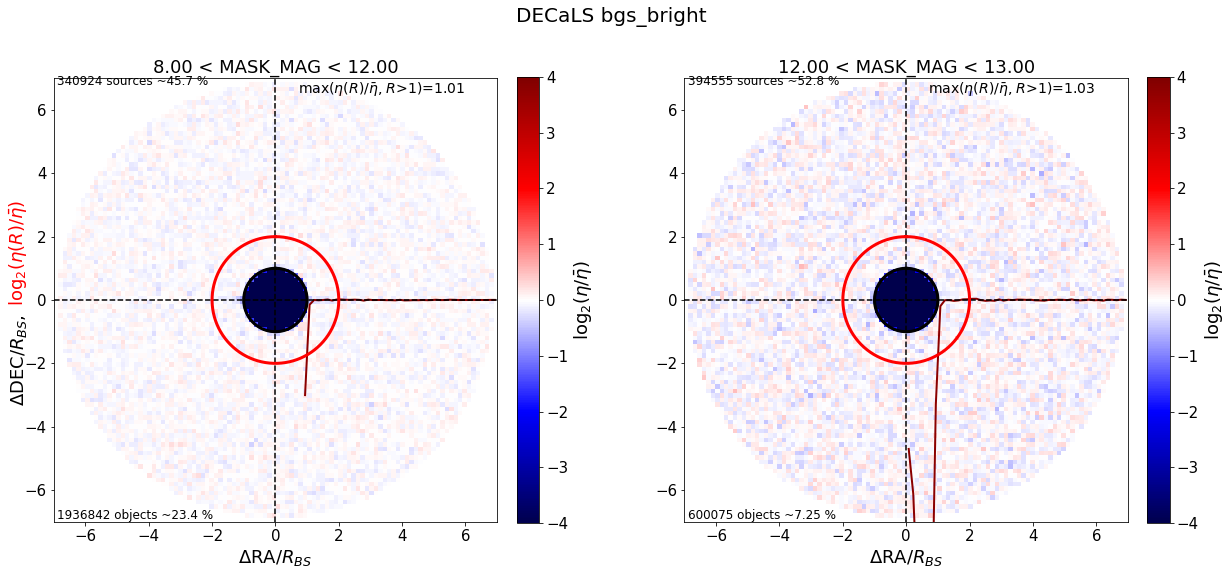

mag_bins_len: 2


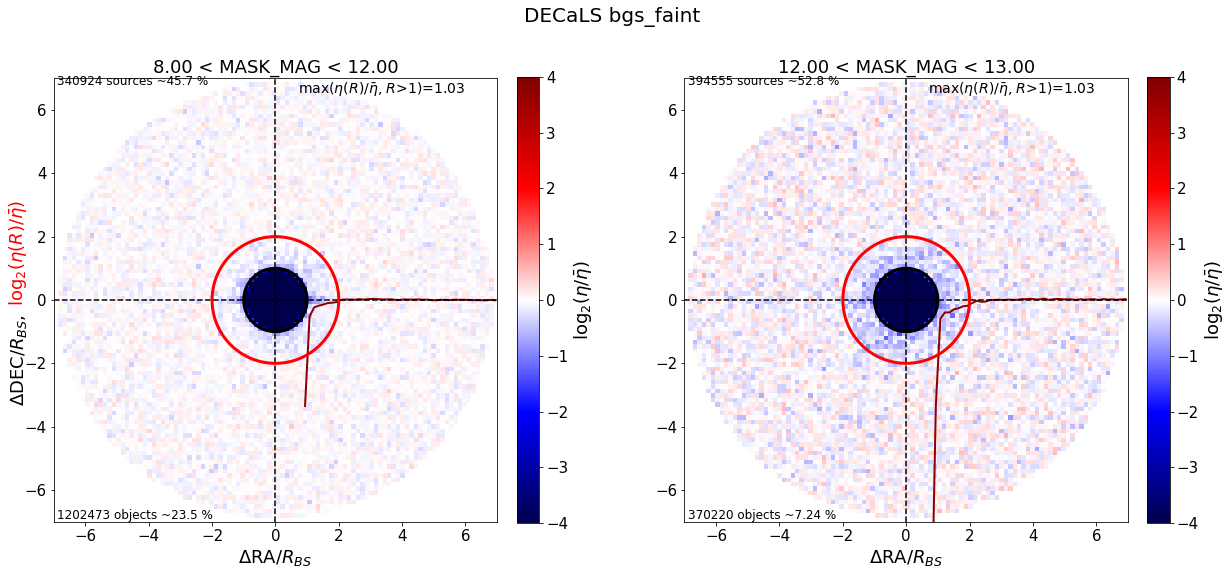

mag_bins_len: 2


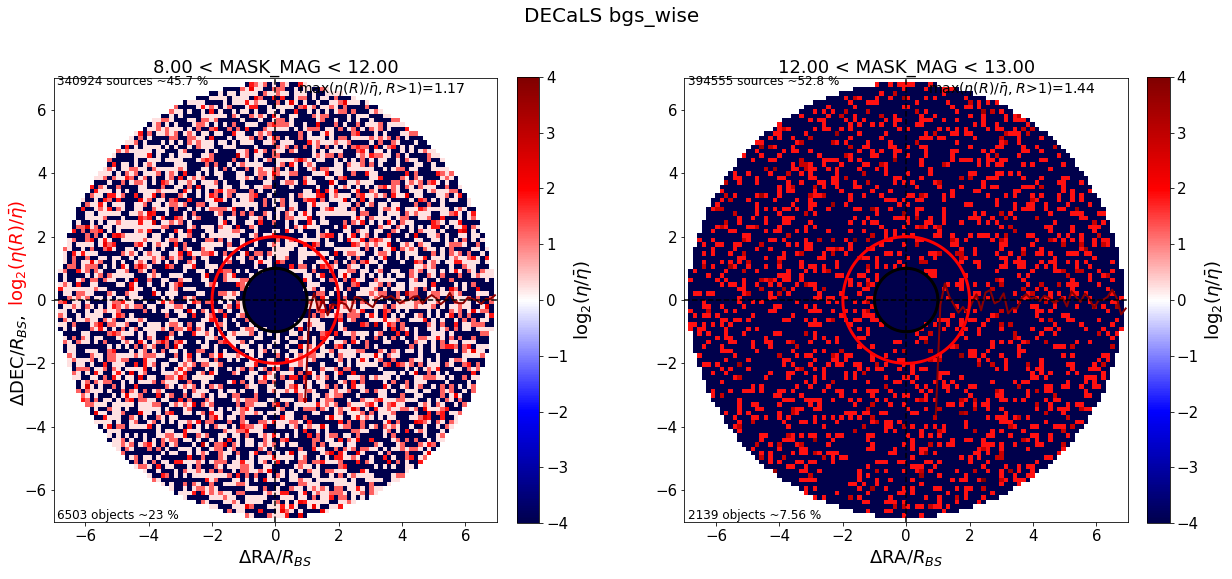

mag_bins_len: 2


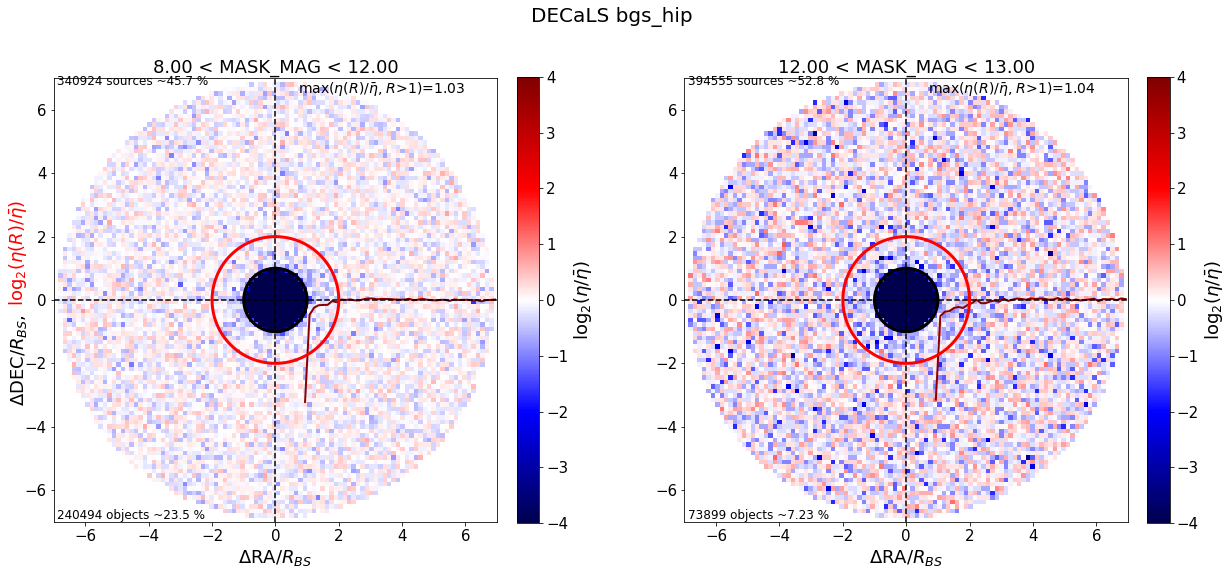

mag_bins_len: 2


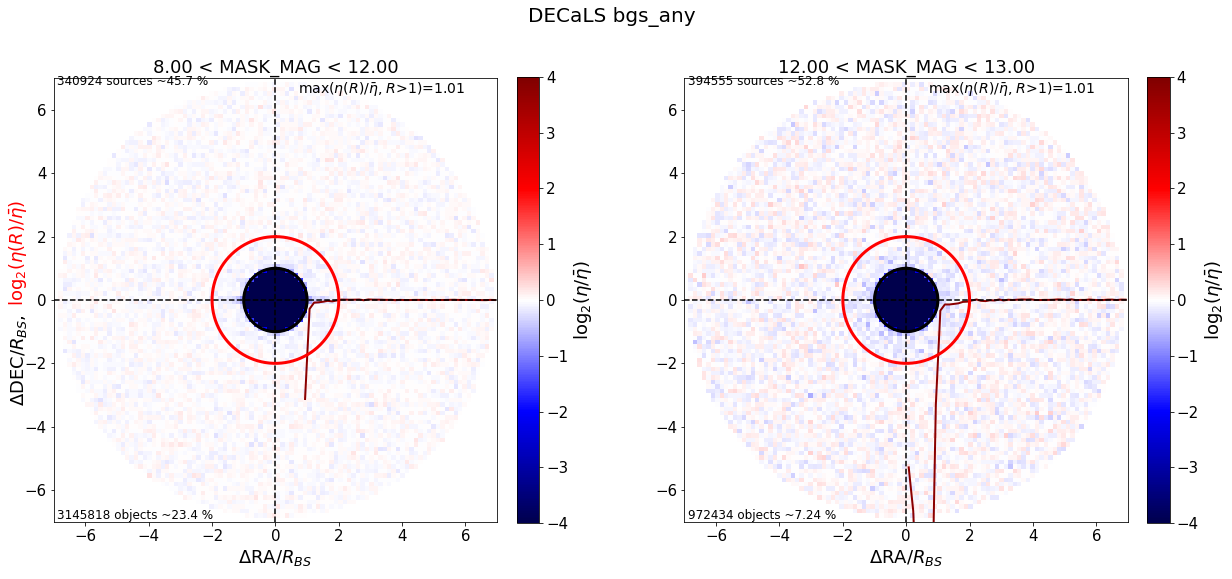

In [39]:
#

for regi, val in regis.items():
    for key, val2 in main.items():
    
        filename = os.path.join(pathdir, '2Dstacks_BS_%s_%s' %(regi, key))

        mask = (val2) & (val)

        log = False
        nbins = 101

        plt.figure(figsize=(20,10))
        plt.title(r'%s %s' %(regi, key), size=20)
        plt.axis('off')

        d2d2, d_ra2, d_dec2, annMask = overdensity(cat[mask], stars[regis_stars[regis_dict[regi]]], dr9_BS_radii, 'MASK_MAG', 35, density=False, 
                                magbins=[8,12,13], radii_2=None, grid=[1,2], SR=[0.1, 500.], scaling=True, nbins=nbins, 
                                       SR_scaling=7,logDenRat=[-4, 4], radii_bestfit=False, annulus=[1.0, 2.0], bintype='0', 
                                           filename=filename, log=log)
        plt.show()
    
    
            

## Systematics

In [65]:
for num, key, val in zip(range(len(regis_dict)), regis_dict.keys(), regis_dict.values()):
    print(num, key, val)

0 BASS+MzLS north
1 DECaLS south


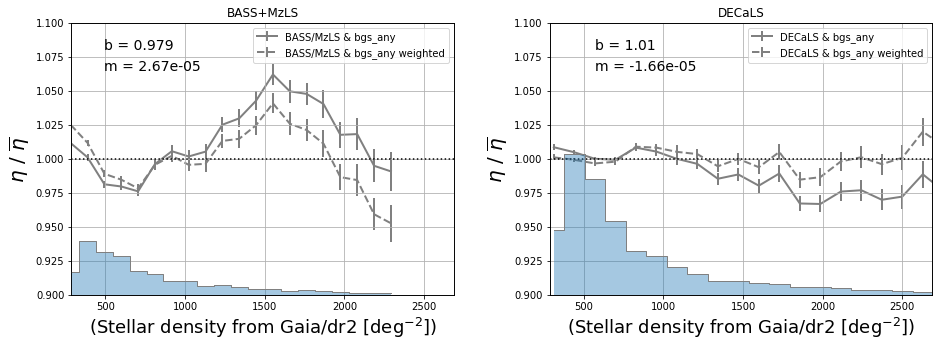

In [66]:
fig    = plt.figure(figsize=(24,5))
gs     = gridspec.GridSpec(1,3,hspace=0.30,wspace=0.25)
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) #this should be rename as "mainreg"
nx         = 20

for num, key, val in zip(range(len(regis_dict)), regis_dict.keys(), regis_dict.values()):
    plot_sysdens(hpdicttmp=hpdict, namesels=['bgs_any'], regs=[val], syst='stardens', mainreg=isdesi, xlim=None, n=num, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=True, fig=fig, gs=gs, title=key, label=True)
    
filename = os.path.join(pathdir, 'systematics_main_stellar')        
fig.savefig(filename+'.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)


In [91]:
#dic WEIGHTED

ws = 1./((-3.96*10**(-5))*hpdict['stardens'] + 1.03)

hpdict_ws = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels={'bgs_any':20, 'bright':21, 'faint':22}, 
                                  galb=galb, log=True, survey='bgs', ws=ws)

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgs_any
computing for  north / bright
computing for  north / faint
target densities in north DONE...
computing for  south / bgs_any
computing for  south / bright
computing for  south / faint
target densities in south DONE...
meandens_bgs_any_all = 1429 /deg2
meandens_bgs_any_des = 1416 /deg2
meandens_bgs_any_decals = 1430 /deg2
meandens_bgs_any_north = nan /deg2
meandens_bgs_any_south = 1429 /deg2
meandens_bgs_any_svfields = 1450 /deg2
meandens_bgs_any_svfields_n = nan /deg2
meandens_bgs_any_svfields_s = 1450 /deg2
meandens_bright_all = 849 /deg2
meandens_bright_des = 842 /deg2
meandens_bright_decals = 850 /deg2
meandens_bright_north = nan /deg2
meandens_bright_south = 849 /deg2
meandens_bright_svfields = 856 /deg2
meandens_bright_svfields_n = nan /deg2
meandens_bright_svfields_s = 856 /deg2
meandens_faint_all = 58

In [23]:
from QA import pixhistregs

In [20]:
list(regis_dict.values())

['north', 'south_s', 'south_n']

In [41]:
pathdir

'/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr9-desi_0.1.0_clustering_paper'

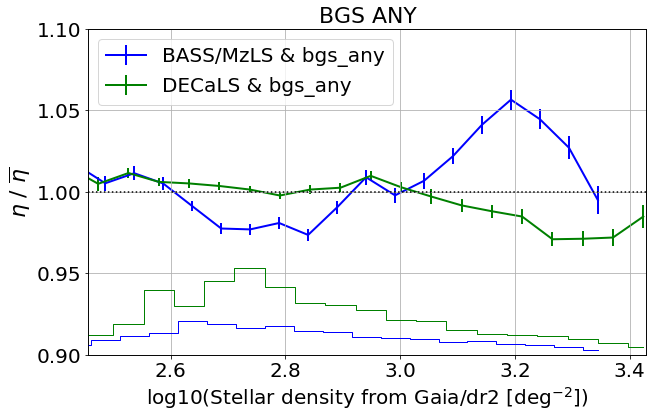

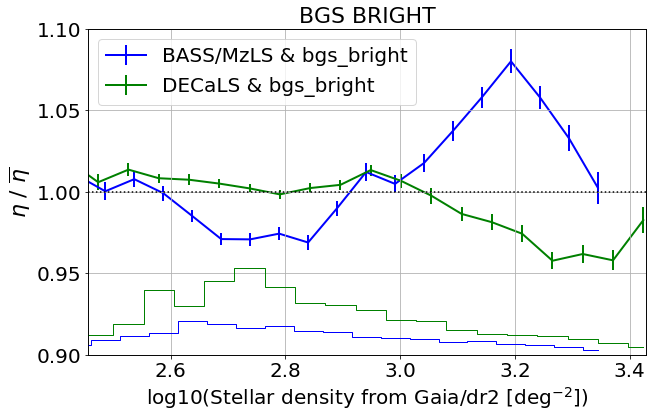

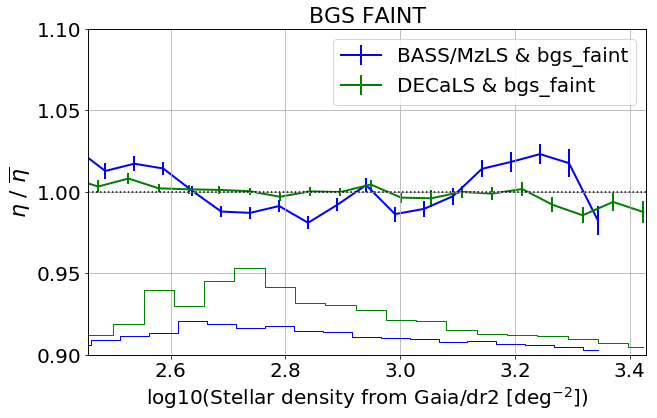

In [72]:
#

syst = 'log10_stardens'
regis_val = list(regis_dict.values())
cols = ['blue', 'green', 'red']
regs_dict = {'north':'BASS/MzLS', 'south':'DECaLS'}
namesels_dict = {'bgs_any': 'BGS ANY', 'bgs_bright':'BGS BRIGHT', 'bgs_faint':'BGS FAINT'}

for i in (['bgs_any'], ['bgs_bright'], ['bgs_faint']):
    
    fig    = plt.figure(figsize=(10,6))
    gs     = gridspec.GridSpec(1,1,hspace=0.30,wspace=0.25)
    
    ax = plot_sysdens(hpdicttmp=hpdict, namesels=i, regs=regis_val, syst=syst, mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                             denslims=False, ylab=True, weights=False, fig=fig, gs=gs, label=True, cols=cols, labels_size=(20,22), 
                                  regs_dict=regs_dict)

    #ax.set_xticks(fontsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax.legend(fontsize=20)
    
    title=namesels_dict[i[0]]
    ax.set_title(title, size=22)

    fig.savefig('%s/systematics_main_bgs_%s_%s_%s.png' %(pathdir, survey, i[0], syst), bbox_inches = 'tight', pad_inches = 0)


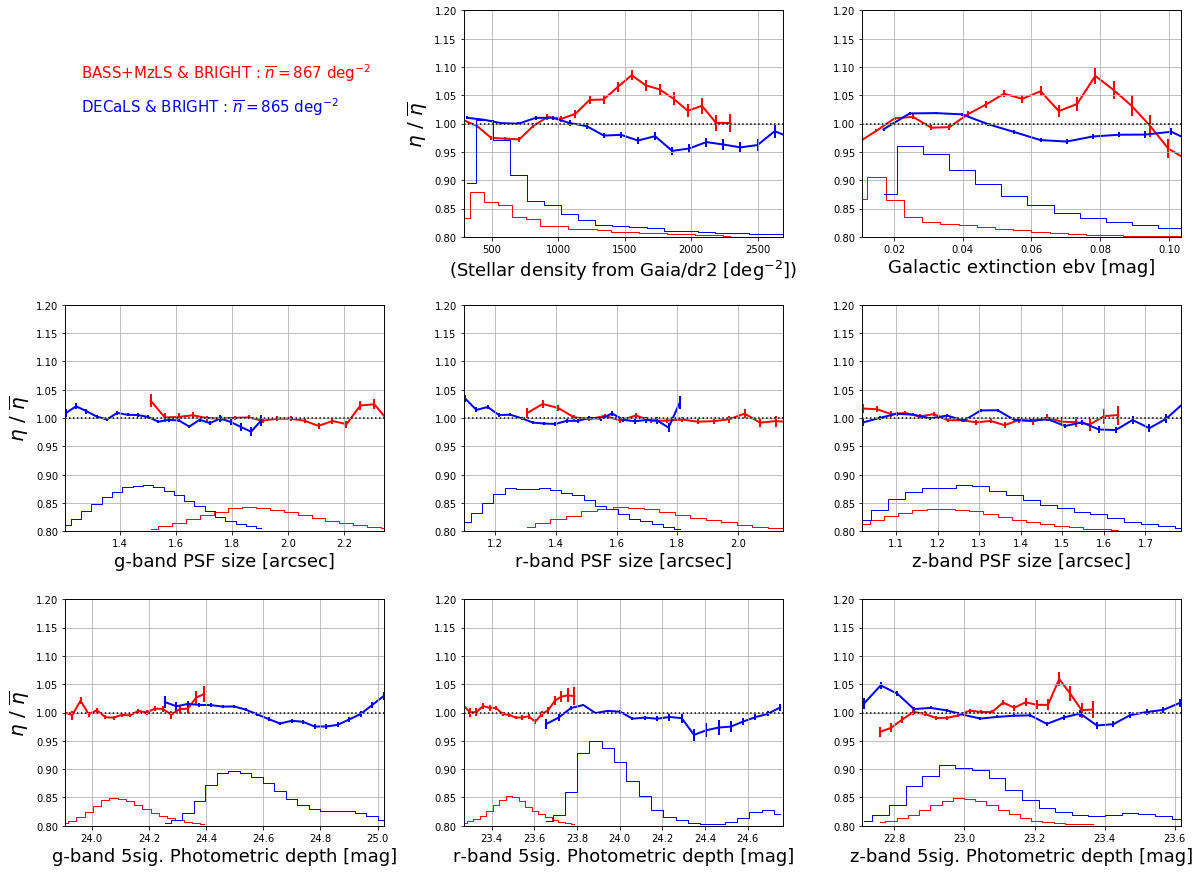

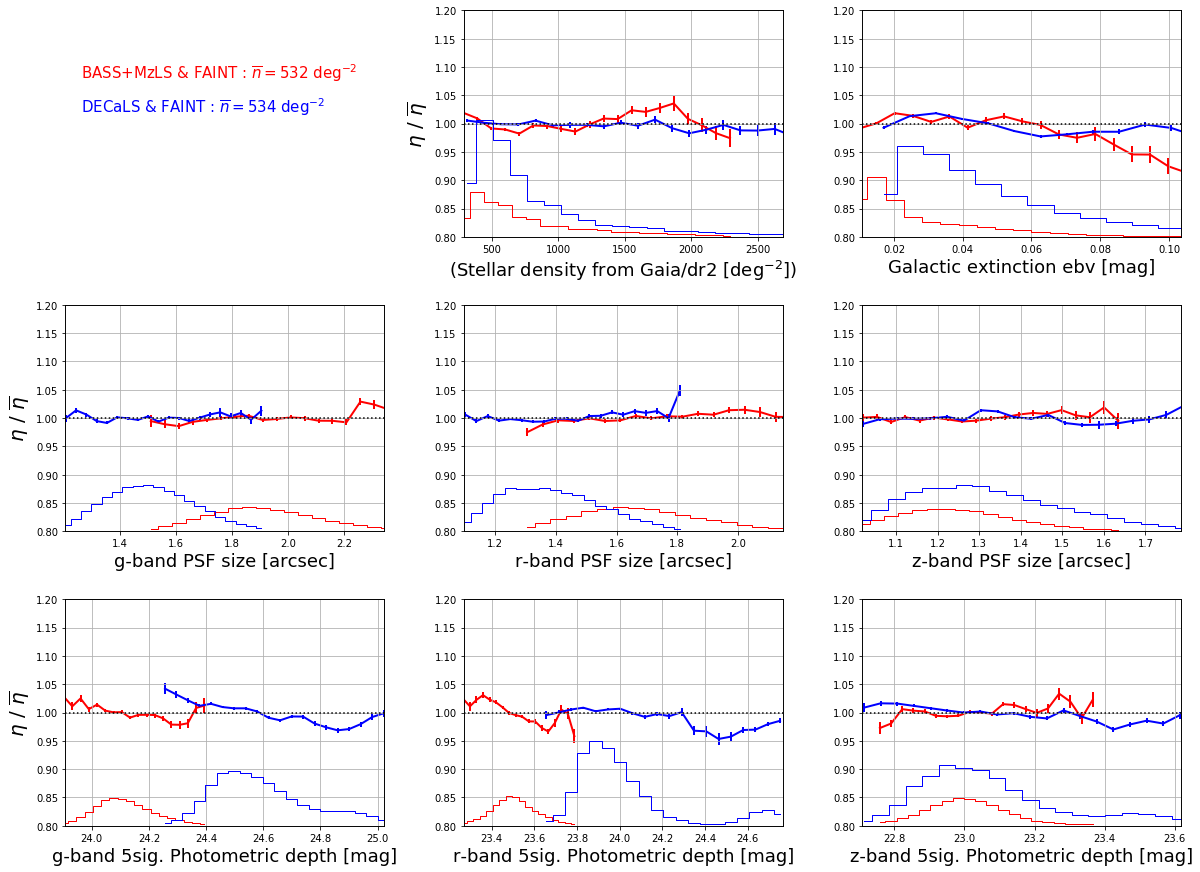

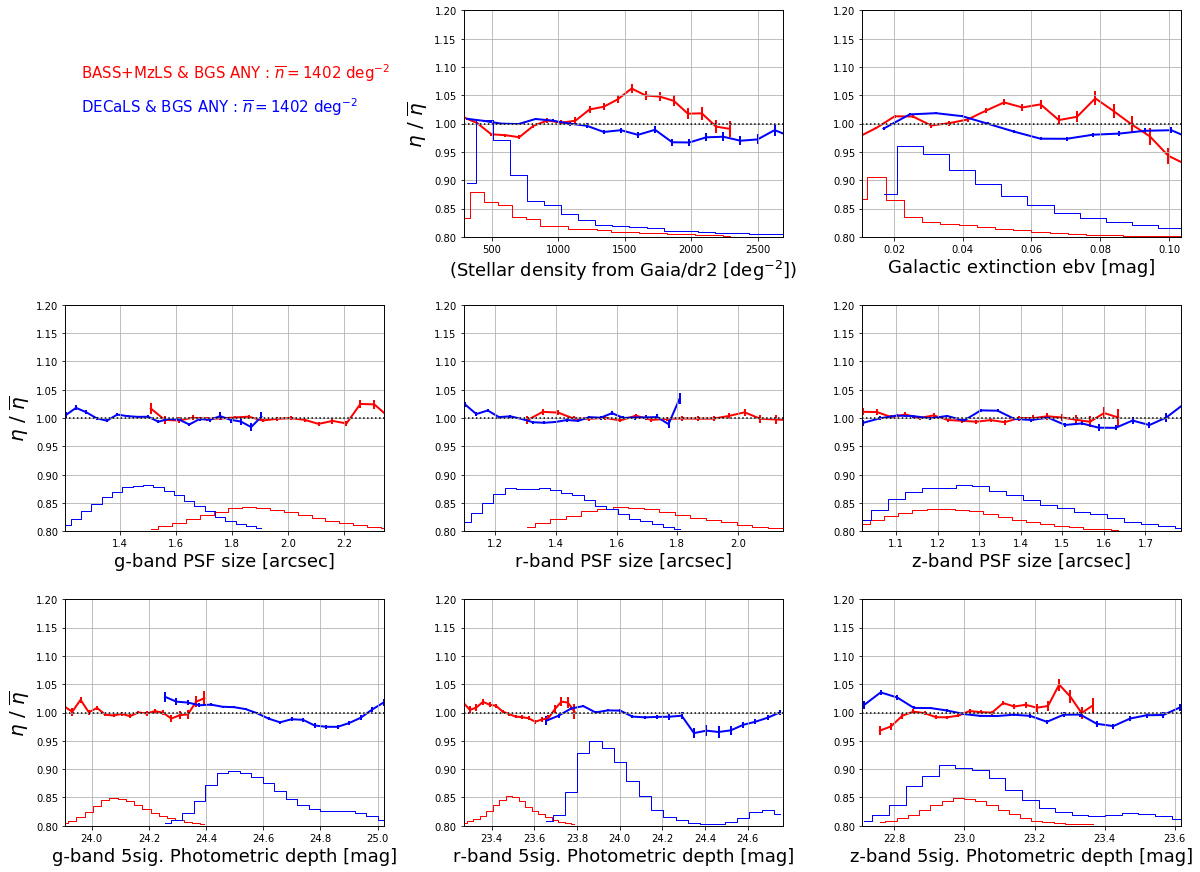

In [82]:
# dr8_south+north : density distributions + systematics


for namesel in ['bgs_bright', 'bgs_faint', 'bgs_any']:

    # settings
    isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) #this should be rename as "mainreg"
    #systs      = ['log10_stardens','ebv']
    systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
    nx         = 20
    #cols       = ['0.5','b','g','r']
    cols = ['red', 'blue', 'green']
    #regs = [reg]
    namesels=[namesel]
    regis_names = list(regis_dict.keys())
    regis_val = list(regis_dict.values())

    regs_dict = {'north':'BASS/MzLS', 'south':'DECaLS'}
    namesels_dict = {'bgs_any': 'BGS ANY', 'bgs_bright':'BRIGHT', 'bgs_faint':'FAINT'}
    #

    # looping on subselections
    #for key, title in zip([None, ws], ['UNWEIGHTED', 'WEIGHTED']):
    for key, title in zip([hpdict], ['UNWEIGHTED']):

        # systematics
        fig    = plt.figure(figsize=(20,15))
        gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)

        for i in range(len(systs)+1):

            if i == 0:
                axinfo = fig.add_subplot(gs[i])
                # infos
                axinfo.axis('off')
                #axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
                tmpy = 0.7
                #for regi,col in zip(regs,cols):
                #if regi == 'south':reg_ = 'DECaLS'
                #elif regi == 'north':reg_ = 'BASS/MzLS'
                #elif regi == 'desi': reg_ = 'DESI'
                #else: reg_ = regi
                for regi,col in zip(regis_names,cols):
                    #if regi == 'desi':
                    #    tmpstr = reg_+' & '+namesel+' : '+r'$\overline{n}=$'+'%.0f'%hpdict['meandens_'+namesel+'_'+'all']+r' deg$^{-2}$'
                    #else:
                    tmpstr = regi+' & '+namesels_dict[namesels[0]]+' : '+r'$\overline{n}=$'+'%.0f'%hpdict['meandens_'+namesels[0]+'_'+regis_dict[regi]]+r' deg$^{-2}$'
                    axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=15,transform=axinfo.transAxes)
                    tmpy  -= 0.15
            else:
                syst = systs[i-1]
                if (i%3==0) or (i==1): ylab=True
                else: ylab = False
                if i == 1: label = True
                else: label = False

                plot_sysdens(hpdicttmp=key, namesels=namesels, regs=regis_val, syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, 
                             denslims=False, ylab=ylab, weights=False, fig=fig, gs=gs, label=False, cols=cols, title=None, ws=None, 
                             regs_dict=regs_dict, ylim=[0.8, 1.2])



        # save fig
        fig.savefig('%s/systematics_main_bgs_%s_%s_%s.png' %(pathdir, survey, title, namesel), bbox_inches = 'tight', pad_inches = 0)
        print('')
        print('')

# Postage Images